In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')

df_jo = pm.df('df_jo')
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])

df_jo_cp = df_jo.copy()

## probando k-means / clustering

In [3]:
df_transformado = df_jo_cp.copy()

# Convertir columnas datetime a timestamps
for col in df_transformado.select_dtypes(include=['datetime64']).columns:
    df_transformado[col] = df_transformado[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)
    
# Convertir columnas slot en enteros
df_transformado['created_at_slot'] = pd.to_numeric(df_transformado['created_at_slot'], errors='coerce').astype('Int64')
df_transformado['created_at_dow'] = pd.to_numeric(df_transformado['created_at_dow'], errors='coerce').astype('Int64')

# Reasignar valores en la columna 'transfer_type' y 'charge_moment' para convertirlo a numéricas
df_transformado = df_transformado.copy()
df_transformado['transfer_type'] = df_transformado['transfer_type'].map({'regular': 0, 'instant': 1})
df_transformado['charge_moment_numeric'] = df_transformado['charge_moment'].fillna('null').map({
    'before': 1,
    'after': 2,
    'null': 0  # Asigna 0 para los valores nulos llenados como 'null'
})
df_transformado['category'] = df_transformado['category'].fillna('null').map({'rejected': 1, 'month_delay_on_payment': 2, 'null':0})

# Descartar columna categorica
df_transformado=df_transformado.drop(columns=['charge_moment'])

# Convertir timedelta a float en días
df_transformado['to_receive_ini'] = df_transformado['to_receive_ini'] / pd.Timedelta(days=1)
df_transformado['to_receive_bank'] = df_transformado['to_receive_bank'] / pd.Timedelta(days=1)
df_transformado['to_reimbur'] = df_transformado['to_reimbur'] / pd.Timedelta(days=1)
df_transformado['to_reimbur_cash'] = df_transformado['to_reimbur_cash'] / pd.Timedelta(days=1)
df_transformado['to_end'] = df_transformado['to_end'] / pd.Timedelta(days=1)
df_transformado['to_send'] = df_transformado['to_send'] / pd.Timedelta(days=1)

# Variable categorica type a numérica
df_transformado['type'] = df_transformado['type'].fillna('null').map({
    'instant_payment': 1,
    'split_payment': 2,    
    'incident': 3 ,
    'postpone' : 4,
    'null' : 0
})

# Variable categorica recovery_Status a numérica
df_transformado['recovery_status'] = df_transformado['recovery_status'].fillna('null').map({
    'completed': 1,
    'pending': 2,    
    'pending_direct_debit': 3 ,
    'null' : 0
})

# Variable categorica stat_cr a numérica
df_transformado['stat_cr'] = df_transformado['stat_cr'].fillna('null').map({
    'approved': 1,
    'money_sent': 2,    
    'rejected': 3 ,
    'pending': 4,
    'transaction_declined': 5,
    'waiting_user_information': 6,
    'direct_debit_rejected': 7,
    'canceled': 8,
    'direct_debit_sent': 9,
    'waiting_reimbursement': 10,
    'active': 11,
    'money_back': 12,    
    'null' : 0
})

# Variable categorica stat_fe a numérica
df_transformado['stat_fe'] = df_transformado['stat_fe'].fillna('null').map({
    'confirmed': 1,
    'rejected': 2,    
    'cancelled': 3 ,
    'accepted': 4,
    'null' : 0
})

# Descartar columnas repetidas
df_transformado=df_transformado.drop(columns=['created_at_d','created_at_slot_h','Mes_created_at'])

# Descartar columnas sin interés
df_transformado=df_transformado.drop(columns=['reason'])

In [4]:
# Crear el escalador
scaler = StandardScaler()

# Estandarizar todas las columnas
normalizado = scaler.fit_transform(df_transformado)

# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
df_transformado = pd.DataFrame(normalizado, columns=df_transformado.columns, index=df_transformado.index)

df_transformado.fillna(0, inplace=True)


df_transformado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_cr                       32092 non-null  float64
 1   id_fe                       32092 non-null  float64
 2   fe_cr_id                    32092 non-null  float64
 3   user_id                     32092 non-null  float64
 4   active                      32092 non-null  float64
 5   created_at                  32092 non-null  float64
 6   created_at_fe               32092 non-null  float64
 7   amount                      32092 non-null  float64
 8   fee                         32092 non-null  float64
 9   stat_cr                     32092 non-null  float64
 10  stat_fe                     32092 non-null  float64
 11  transfer_type               32092 non-null  float64
 12  type                        32092 non-null  float64
 13  to_receive_ini              320

In [5]:
user_id=df_transformado['user_id']
df_transformado=df_transformado.drop(columns=['needs_m_check','user_id','n_incidents','n_recovery','n_backs','n_fees','needs_m_check_recov'])

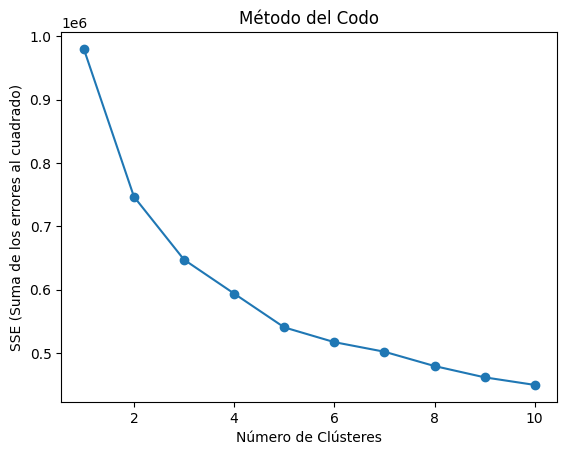

,id_cr,id_fe,fe_cr_id,active,created_at,created_at_fe,amount,fee,stat_cr,stat_fe,...,reco_last_update,updated_at_fe,cash_request_received_date,created_at_slot,created_at_dow,GBP_EUR,BTC_GBP,inflation,unemploy_rate,charge_moment_numeric
cluster,,,,,,,,,,,,,,,,,,,,,
0,-1.083634,-0.540170,-1.582504,-0.097524,-0.849438,-1.466402,0.333892,0.723866,0.370209,-0.382269,...,-0.332495,-0.091603,-0.987186,0.070116,-0.024105,0.042384,-0.820372,0.539629,-1.114127,0.588076
1,1.230994,1.328128,0.980782,0.224361,1.020894,0.840332,-0.401118,0.702207,0.500978,0.154325,...,0.140316,0.372646,0.926853,-0.035964,0.088302,-0.059431,1.071524,0.232287,0.792604,0.671473
2,-1.213112,-0.988067,0.000000,-0.238731,-1.288342,0.000000,0.392056,-1.381090,-0.613775,0.000000,...,-0.065147,0.000000,-0.809082,0.068029,-0.053121,0.119122,-1.111307,0.910542,-1.377701,-1.289237
3,0.175223,-0.164215,-0.144705,0.011201,0.276328,-0.091004,-0.049694,0.055178,-0.108783,0.016998,...,0.044584,-0.207069,0.129202,-0.033416,-0.020931,-0.036752,0.144425,-0.777149,0.545039,0.067618


In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Usar los datos ya escalados para clustering
data_scaled = df_transformado  # Asumiendo que ya está escalado

# Encontrar el número óptimo de clústeres (método del codo)
sse = []
for k in range(1, 11):  # Probar de 1 a 10 clústeres
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)

# Graficar el método del codo
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Número de Clústeres')
plt.ylabel('SSE (Suma de los errores al cuadrado)')
plt.title('Método del Codo')
plt.show()

# Elegir un número de clústeres basado en el gráfico (por ejemplo, 3)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# Agregar los clústeres al DataFrame original
df_transformado['cluster'] = clusters

# Ver resultados
results=df_transformado.groupby('cluster').mean()  # Promedio de características por grupo
results

In [7]:
from sklearn.cluster import KMeans

# Entrenar KMeans con 4 clústeres
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_scaled)  # Usamos los datos escalados (suponiendo que ya los tienes)

# Predecir el clúster para cada registro
clusters = kmeans.predict(data_scaled)

# Agregar la columna 'cluster' al DataFrame original
df_transformado['cluster'] = clusters

# Ver el número de registros en cada clúster
df_transformado['cluster'].value_counts()


cluster
3    8993
1    8262
2    7756
0    7081
Name: count, dtype: int64

In [8]:
# Si guardaste 'user_id' antes de hacer el clustering:
df_transformado['user_id'] = user_id

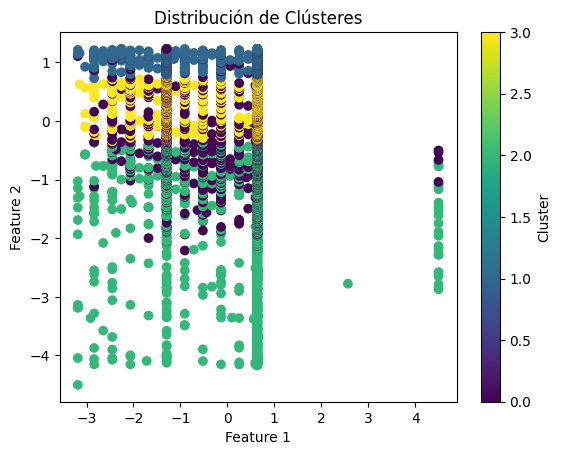

In [10]:
import matplotlib.pyplot as plt

# Seleccionar dos características para la visualización 
plt.scatter(df_transformado['amount'], df_transformado['created_at'], c=df_transformado['cluster'], cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Distribución de Clústeres')
plt.colorbar(label='Cluster')
plt.show()


Investigar en cada cluster qué tipo de clientes hay a ver si tiene algun sentido y se pueden dar insight accionables para cada cluster que beneficien a la empresa.